In [1]:
%load_ext autoreload
%autoreload 2

# System imports
from typing import NamedTuple, Callable
import time

import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import networkx as nx

import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import numpy as np
import optax

import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi

# Local imports
import loss
from model import VGAE, VGAEOutput, decoder
import plotting

print(f"JAX version: {jax.__version__}")
print(f"Numpyro version: {numpyro.__version__}")

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


JAX version: 0.3.13
Numpyro version: 0.9.2


In [2]:
RNG_KEY = jax.random.PRNGKey(42)

In [3]:
import sys

USE_TPU = True

if USE_TPU and "google.colab" in sys.modules:
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  
if jax.default_backend() == 'cpu':
  numpyro.set_host_device_count(4)

jax.local_device_count()

1

In [4]:
# Grid definition.
k = 1
num_x = 15 * k
num_y = 10 * k

# Generate polygons.
polygons = []
for j in range(num_y):
  for i in range(num_x):
    coords = [(i,j), (i+1, j), (i+1, j+1), (i, j+1), (i,j)]
    polygons.append(Polygon(coords))
    
num_regions = len(polygons)

# Adjacency matrix.
A = np.zeros(shape=(num_regions, num_regions))
for i in range(num_regions):
  for j in range(i+1,num_regions):
    polygons_intersect = (
      polygons[i].intersection(polygons[j]).length > 0)
    if polygons_intersect:
      A[i, j] = A[j, i] = 1

# Number of neighbours.
d = A.sum(axis=0)
D = jnp.diag(d)
np.linalg.det(np.linalg.inv(D - A))

0.0

In [5]:
def CAR(args):
  A = args['A']
  D = jnp.diag(args['d'])

  # alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
  alpha = 0.5

  Q = (D - alpha*A)
  numpyro.sample('car', dist.MultivariateNormal(loc=jnp.zeros(num_regions), precision_matrix=Q))

In [6]:
args = {
  'd': d,
  'A': A,
  'batch_size': 1000,
}

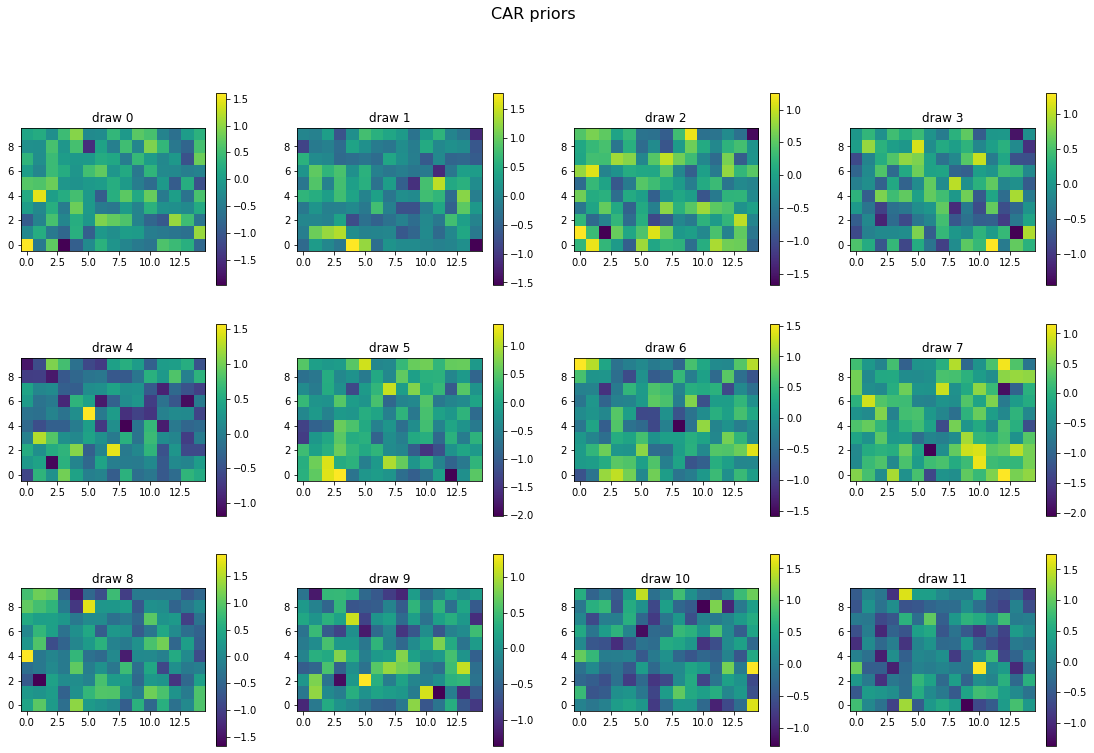

In [7]:
# CAR: prior predictive
RNG_KEY, car_pred_rng = jax.random.split(RNG_KEY)

car_preds = Predictive(CAR, num_samples=args['batch_size'])(car_pred_rng, args)
car_draws = car_preds['car']

plotting.plot_samples(car_draws)

In [37]:
def create_grid_graph(adj_matrix: np.ndarray) -> jraph.GraphsTuple:
  G = nx.from_numpy_matrix(adj_matrix)

  edges = list(G.edges)
  edges += [(edge[1], edge[0]) for edge in edges]
  senders = jnp.asarray([edge[0] for edge in edges])
  receivers = jnp.asarray([edge[1] for edge in edges])

  return jraph.GraphsTuple(
    n_node = jnp.asarray([len(G.nodes)]),
    n_edge = jnp.asarray([len(edges)]),
    nodes=None,
    edges=None,
    globals=None,
    senders=senders, 
    receivers=receivers)

def get_car_draws_as_graph(car_draws: jnp.ndarray) -> jraph.GraphsTuple:
  graph = create_grid_graph(adj_matrix=A)
  return graph._replace(nodes=car_draws)
  
dataset_graphs = []
dataset = []
for i in range(args['batch_size']):
  g = get_car_draws_as_graph(car_draws[i].reshape(-1, 1))
  dataset_graphs.append(g)
  dataset.append({
    'input_graph': g, 
    'target': g.nodes,
  })

train_size = int(len(dataset) * 0.5)
train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:]

print('Train size:', len(train_dataset))
print('Validation size:', len(val_dataset))

batch_size = train_size

In [9]:
assert len(train_dataset) == len(val_dataset), 'Current VGAE implementation requires train and val dataset to be of same length for batching.'

In [10]:
# Batching
train_dataset_graphs = dataset_graphs[:train_size]
val_dataset_graphs = dataset_graphs[train_size:]
train_graph_batch = jraph.batch(train_dataset_graphs)
val_graph_batch = jraph.batch(val_dataset_graphs)

/Users/salmanfaris/miniforge3/envs/prior-vgae/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [11]:
# See graph statistics for a single graph
train_graph = train_dataset[0]['input_graph']
train_labels = train_graph.nodes

num_nodes = train_graph.n_node.item()
feat_matrix_dim = train_graph.nodes.shape
assert num_nodes == feat_matrix_dim[0], 'num_nodes != feat_matrix_dim[0]'
assert feat_matrix_dim == train_labels.shape, 'feat_matrix_dim != train_labels.shape'
print('Number of nodes:', num_nodes)
print('Feature matrix dim (n_node x n_feat):', feat_matrix_dim)
print('Targets shape:', train_labels.shape)

Number of nodes: 150
Feature matrix dim (n_node x n_feat): (150, 1)
Targets shape: (150, 1)


In [12]:
LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

class Args(NamedTuple):
  loss_fn: LossFun
  
  hidden_gnn_dim: int = 200
  hidden_fc_dim: int = 150
  latent_dim: int = 50
  output_dim: int = 1
  
  batch_size: int = batch_size
  num_nodes: int = num_nodes
  
  learning_rate: float = 1e-2
  epochs: int = 1000
  eval_frequency: int = 50

# Loss options include:
# [
#   loss.compute_mse_loss,
#   loss.compute_frobenius_loss,
#   loss.compute_L21_loss,
#   loss.compute_Lpq_loss,
# ]
ARGS = Args(loss_fn=loss.compute_mse_loss)
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x167555c10>, hidden_gnn_dim=200, hidden_fc_dim=150, latent_dim=50, output_dim=1, batch_size=500, num_nodes=150, learning_rate=0.01, epochs=1000, eval_frequency=50)


In [13]:
RNG_KEY, params_key = jax.random.split(RNG_KEY)

# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_gnn_dim=ARGS.hidden_gnn_dim,
                 hidden_fc_dim=ARGS.hidden_fc_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim,
                 batch_size=ARGS.batch_size,
                 num_nodes=ARGS.num_nodes)(x))
optimizer = optax.adam(ARGS.learning_rate)

In [14]:
from model import VGAEOutput

@jax.jit
def loss_fn(params: hk.Params, 
            rng_key: jnp.ndarray,
            graph: jraph.GraphsTuple,
            targets: jnp.ndarray,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood_loss_fn = ARGS.loss_fn # mse_loss
  log_likelihood = -log_likelihood_loss_fn(
    outputs.output.nodes, targets)
  kld = 1/num_nodes * jnp.mean(
    loss.compute_kl_gaussian(
      outputs.mean, outputs.log_std), axis=-1)
  elbo = log_likelihood - kld
  return -elbo
  
@jax.jit
def update(
params: hk.Params,
rng_key: jnp.ndarray,
opt_state: optax.OptState,
graph: jraph.GraphsTuple,
targets: jnp.ndarray,
):
  """Updates the parameters of the network."""
  grads = jax.grad(loss_fn)(params, rng_key, graph, targets)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [15]:
# Initialize net with an arbitrary graph in dataset
# init_graph = train_dataset[0]['input_graph']
init_graph = train_graph_batch
params = net.init(params_key, init_graph)
opt_state = optimizer.init(params)

In [16]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):    
  update_rng = jax.random.fold_in(train_rng, epoch)
    
  params, opt_state = update(params, update_rng, opt_state, 
                             train_graph_batch, train_graph_batch.nodes)

  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    loss_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(loss_rng)
    
    train_loss = loss_fn(params, train_loss_rng, train_graph_batch, train_graph_batch.nodes)
    val_loss = loss_fn(params, eval_loss_rng, val_graph_batch, val_graph_batch.nodes)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
                f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}')
    
    # if (len(train_losses) > 1) and (np.isclose(train_loss, train_losses[-1])):
    #   break
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x167555c10>
14:25:17 STEP: 0; Train loss: 697527303884932081765467553792.000; Validation loss: 1673843782105374182880751648768.000
14:25:37 STEP: 50; Train loss: 835894530779605834384845832192.000; Validation loss: 2027273547701165925763395878912.000
14:25:56 STEP: 100; Train loss: 1109676334370272059693029392384.000; Validation loss: 3377360346221734535197372710912.000
14:26:15 STEP: 150; Train loss: 731587353253163466390669099008.000; Validation loss: 3772093666907569891148440797184.000
14:26:35 STEP: 200; Train loss: 493370900570808153816004820992.000; Validation loss: 1456427389275602783700009353216.000
14:26:54 STEP: 250; Train loss: 2297460761482935503049237463040.000; Validation loss: 1767119662643560511484381364224.000
14:27:13 STEP: 300; Train loss: 757885947743741479885610156032.000; Validation loss: 2943337238629878634725647581184.000
14:27:33 STEP: 350; Train loss: 947714577812043315385234096128.000; Validation loss: 506668366786863678

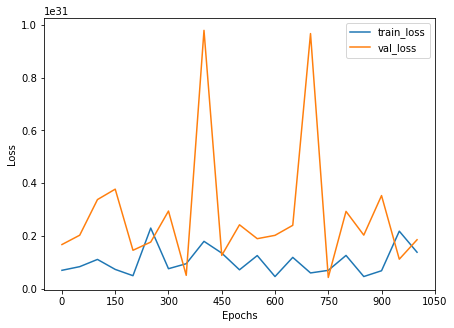

In [17]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure(figsize=(7, 5)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
xs = np.arange(len(train_losses))*ARGS.eval_frequency
plt.plot(xs, train_losses, label='train_loss')
plt.plot(xs, val_losses, label='val_loss')

ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

In [18]:
ARGS

Args(loss_fn=<function compute_mse_loss at 0x167555c10>, hidden_gnn_dim=200, hidden_fc_dim=150, latent_dim=50, output_dim=1, batch_size=500, num_nodes=150, learning_rate=0.01, epochs=1000, eval_frequency=50)

In [21]:
from functools import partial

decoder_params = {
  'decoder_hidden_fc': params['vgae/decoder_hidden_fc'],
  'decoder_hidden_gnn': params['vgae/decoder_hidden_gnn'],
  'decoder_output': params['vgae/decoder_output'],
}

one_graph = train_dataset[0]['input_graph']
decoding_batch_size = 1
decoder_net_fn = partial(decoder,
                         graph=one_graph,  # just need graph structure
                         hidden_gnn_dim=ARGS.hidden_gnn_dim,
                         output_dim=ARGS.output_dim,
                         batch_size=decoding_batch_size,
                         num_nodes=ARGS.num_nodes)
decoder_net = hk.without_apply_rng(hk.transform(decoder_net_fn))

RNG_KEY, z_rng = jax.random.split(RNG_KEY)
vae_draws = []
for idx in range(args['batch_size']):
  z_rng_idx = jax.random.fold_in(z_rng, idx)
  z = jax.random.normal(z_rng_idx, shape=(decoding_batch_size, ARGS.latent_dim))
  out_graph = decoder_net.apply(decoder_params, z)
  vae_draws.append(out_graph.nodes)

vae_draws = jnp.squeeze(jnp.asarray(vae_draws))
assert vae_draws.shape == car_draws.shape, 'vae_draws dimensions do not match car_draws dimensions'

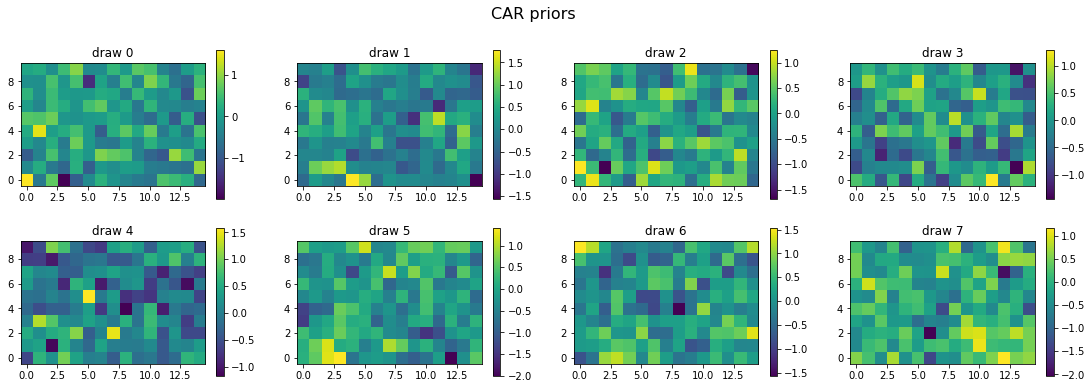

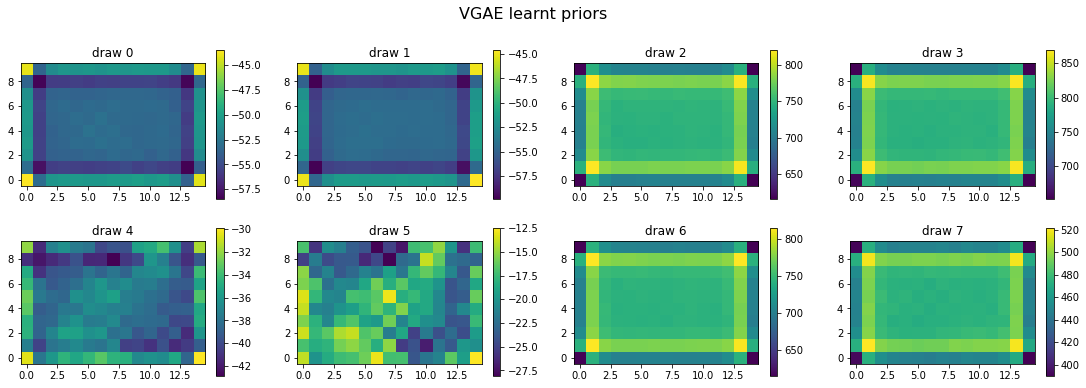

In [22]:
plotting.plot_samples(car_draws, rows=2, figsize=(19, 6))
# plotting.plot_samples(vae_draws, rows=2, figsize=(19, 6), ttl='VGAE learnt priors (min-max-bar scaled)', custom_min=-2, custom_max=2)
plotting.plot_samples(vae_draws, rows=2, figsize=(19, 6), title='VGAE learnt priors')

In [23]:
ARGS

Args(loss_fn=<function compute_mse_loss at 0x167555c10>, hidden_gnn_dim=200, hidden_fc_dim=150, latent_dim=50, output_dim=1, batch_size=500, num_nodes=150, learning_rate=0.01, epochs=1000, eval_frequency=50)

### Inference on observed data with VGAE-CAR

In [24]:
args['decoder_params'] = decoder_params

In [25]:
def CAR_model(args, y=None, alpha=None, noise=None):
    A = args['A']
    D = jnp.diag(args['d'])

    if alpha is None:
        alpha = numpyro.sample('alpha', dist.Uniform(low=0.4, high=0.999))
        
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    Q = (D - alpha*A)
    
    car = numpyro.sample(
        'car', dist.MultivariateNormal(
            loc=jnp.zeros(num_regions), precision_matrix=Q))
    numpyro.deterministic('car_samples', car)
    
    if y is None: # during prediction
        numpyro.sample('y_pred', dist.Normal(car, noise))
    else: # during inference
        numpyro.sample('y', dist.Normal(car, noise), obs=y)

In [26]:
# generate ground truth - fix alpha
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

car_predictive = Predictive(CAR_model, num_samples=1)
car_preds = car_predictive(rng_pred, args, alpha=0.7, noise=0.5)
y_data = car_preds['y_pred'][0,:]
y_truth = car_preds['car'][0,:]

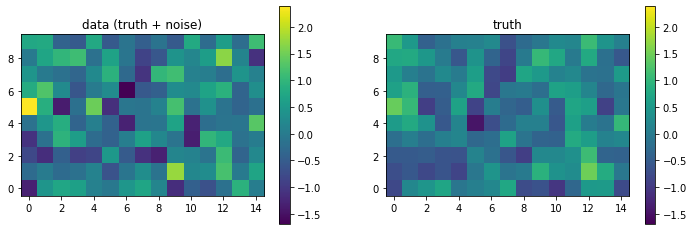

In [27]:
plotting.plot_images_from_arrays(
    arrays=[y_data, y_truth],
    titles=['data (truth + noise)', 'truth'],
)

In [28]:
# args['hidden_dim'] = ARGS.hidden_dim
args['latent_dim'] = ARGS.latent_dim
args['output_dim'] = ARGS.output_dim
args['train_graph'] = train_graph
args['n_node'] = ARGS.num_nodes
args['decoder_net'] = decoder_net

In [29]:
def VAE_model(args, y=None, noise=None):
    z = numpyro.sample("z", dist.Normal(0, 1).expand([args['latent_dim']]))
    
    decoder_params = args["decoder_params"] 
    car_vae = numpyro.deterministic(
        "vae_car", 
        # The transpose is because we initially used 
        # more than one samples ~ N(0, 1) as features for each node
        jnp.squeeze(decoder_net.apply(decoder_params, z).nodes.T))
    
    if noise is None:
        noise = numpyro.sample('noise', dist.Uniform(low=0.01, high=1))
    
    if y is None: # during prediction
        numpyro.sample("y_pred", dist.Normal(car_vae, noise))
    else: # during inference
        numpyro.sample("y", dist.Normal(car_vae, noise), obs=y)

In [30]:
# VAE-CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

prior_predictive = Predictive(VAE_model, num_samples=500)
prior_predictions = prior_predictive(rng_pred, args)

pred_obs = prior_predictions['vae_car']
mean_prior_pred_vae = np.mean(pred_obs, axis=0)
hpdi_prior_pred_vae = hpdi(pred_obs, 0.89)

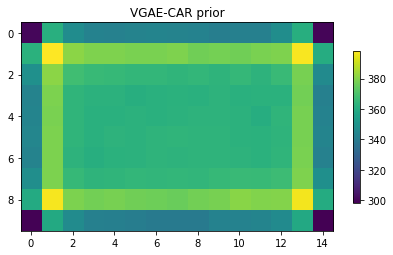

In [31]:
plt.figure(figsize=(7, 7))
plt.imshow(mean_prior_pred_vae.reshape(num_y, num_x)) 
plt.colorbar(shrink=0.4)
plt.title("VGAE-CAR prior")
plt.show()

In [32]:
RNG_KEY, rng_mcmc = jax.random.split(RNG_KEY)

# Inference time
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(VAE_model, init_strategy=init_strategy)
mcmc = MCMC(
    kernel, 
    num_warmup=1000, 
    num_samples=2000
)
mcmc.run(rng_mcmc, args, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

warmup:  27%|██▋       | 812/3000 [07:19<19:44,  1.85it/s, 1023 steps of size 7.37e-03. acc. prob=0.79]


KeyboardInterrupt: 

In [ ]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['vae_car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 44 s
Average ESS for all CAR effects : 1498


In [ ]:
# posterior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)
posterior_predictions = Predictive(VAE_model, mcmc_samples)(rng_pred, args)

post_obs = posterior_predictions['vae_car']
mean_post_pred_vae = np.mean(post_obs, axis=0)
bci_vae_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_vae_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_vae = hpdi(post_obs, 0.9)

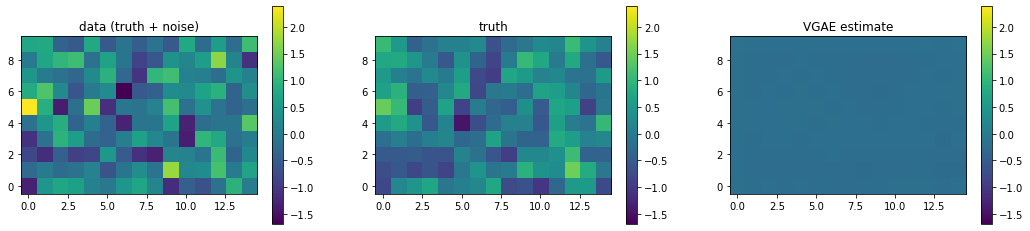

In [ ]:
plotting.plot_images_from_arrays(
    arrays=[y_data, y_truth, mean_post_pred_vae],
    titles=['data (truth + noise)', 'truth', 'VGAE estimate'],
    figsize=(18, 4),
)

mse_vae = 0.38161829113960266


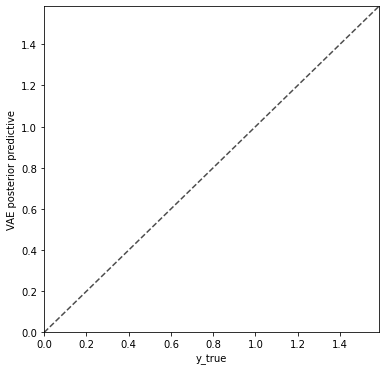

In [ ]:
plotting.plot_compare_estimates(
    data_x=y_truth, data_y=mean_post_pred_vae,
    x_label='y_true', y_label='VAE posterior predictive',
    figsize=(6, 6),
)

mse_vae = np.mean((y_truth -  mean_post_pred_vae)**2)
print(f'mse_vae = {mse_vae}')

### Inference with CAR

In [ ]:
RNG_KEY, rng_mcmc = jax.random.split(RNG_KEY)

# Inference - smooth data and infer alpha
start = time.time()
init_strategy = init_to_median(num_samples=10)
kernel = NUTS(CAR_model, init_strategy=init_strategy)
mcmc = MCMC(
    kernel,
    num_warmup=1000,
    num_samples=2000
)
mcmc.run(rng_mcmc, args, y=y_data)
mcmc_samples = mcmc.get_samples()
mcmc.print_summary(exclude_deterministic=False)
t_elapsed = time.time() - start

sample: 100%|██████████| 3000/3000 [02:41<00:00, 18.52it/s, 15 steps of size 2.60e-01. acc. prob=0.92]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha      0.59      0.12      0.58      0.40      0.76   2757.21      1.00
          car[0]     -0.95      0.38     -0.96     -1.57     -0.34   2742.09      1.00
          car[1]      0.24      0.36      0.25     -0.36      0.81   3638.09      1.00
          car[2]      0.49      0.35      0.49     -0.08      1.06   3124.78      1.00
          car[3]      0.42      0.36      0.44     -0.19      0.96   2816.40      1.00
          car[4]      0.08      0.35      0.08     -0.52      0.63   3231.59      1.00
          car[5]     -0.03      0.36     -0.04     -0.63      0.54   3771.13      1.00
          car[6]      0.32      0.35      0.32     -0.19      0.97   3909.12      1.00
          car[7]      0.49      0.36      0.50     -0.10      1.07   3842.45      1.00
          car[8]      0.08      0.36      0.08     -0.53      0.63   3807.11      1.00
          car[9]     -0.67      0.35     -

In [ ]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 163 s
Average ESS for all CAR effects : 3126


In [ ]:
# posterior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)
posterior_predictions = Predictive(
    CAR_model, mcmc_samples)(rng_pred, args, y=None)

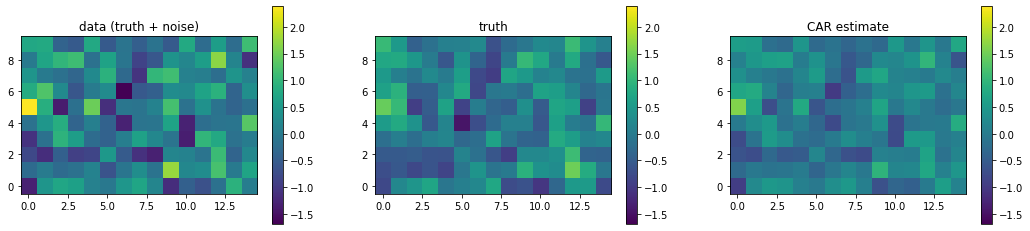

In [ ]:
post_obs = posterior_predictions['car_samples']
mean_post_pred_car = np.mean(post_obs, axis=0)
bci_car_2_5 = np.quantile(post_obs, 0.025, axis=0)
bci_car_97_5 = np.quantile(post_obs, 0.975, axis=0)
hpdi_post_pred_car = hpdi(post_obs, 0.9)

plotting.plot_images_from_arrays(
    arrays=[y_data, y_truth, mean_post_pred_car],
    titles=['data (truth + noise)', 'truth', 'CAR estimate'],
    figsize=(18, 4),
)

mse_car = 0.1445247381925583


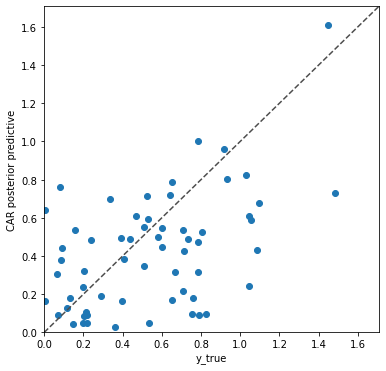

In [ ]:
plotting.plot_compare_estimates(
    data_x=y_truth, data_y=mean_post_pred_car,
    x_label='y_true', y_label='CAR posterior predictive',
    figsize=(6, 6),
)

mse_car = np.mean((y_truth -  mean_post_pred_car)**2)
print(f'mse_car = {mse_car}')

mse_vae_v_car = 0.25503525137901306


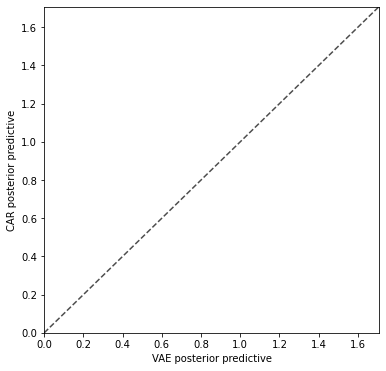

In [ ]:
plotting.plot_compare_estimates(
    data_x=mean_post_pred_vae, data_y=mean_post_pred_car,
    x_label='VAE posterior predictive', y_label='CAR posterior predictive',
    figsize=(6, 6),
)

mse_vae_v_car = np.mean((mean_post_pred_car -  mean_post_pred_vae)**2)
print(f'mse_vae_v_car = {mse_vae_v_car}')

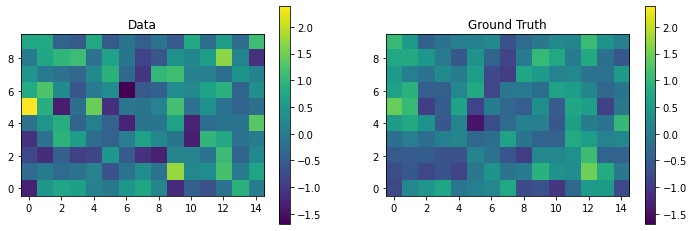

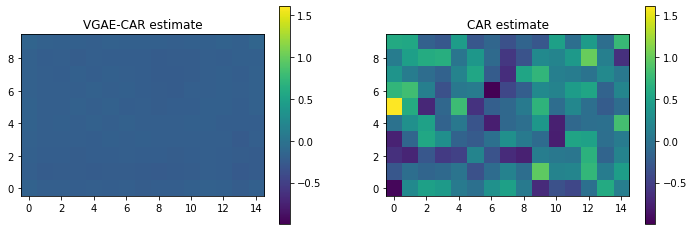

In [ ]:
plotting.plot_images_from_arrays(
    arrays=[y_data, y_truth],
    titles=['Data', 'Ground Truth'],
)

plotting.plot_images_from_arrays(
    arrays=[mean_post_pred_vae, mean_post_pred_car],
    titles=['VGAE-CAR estimate', 'CAR estimate'],
)

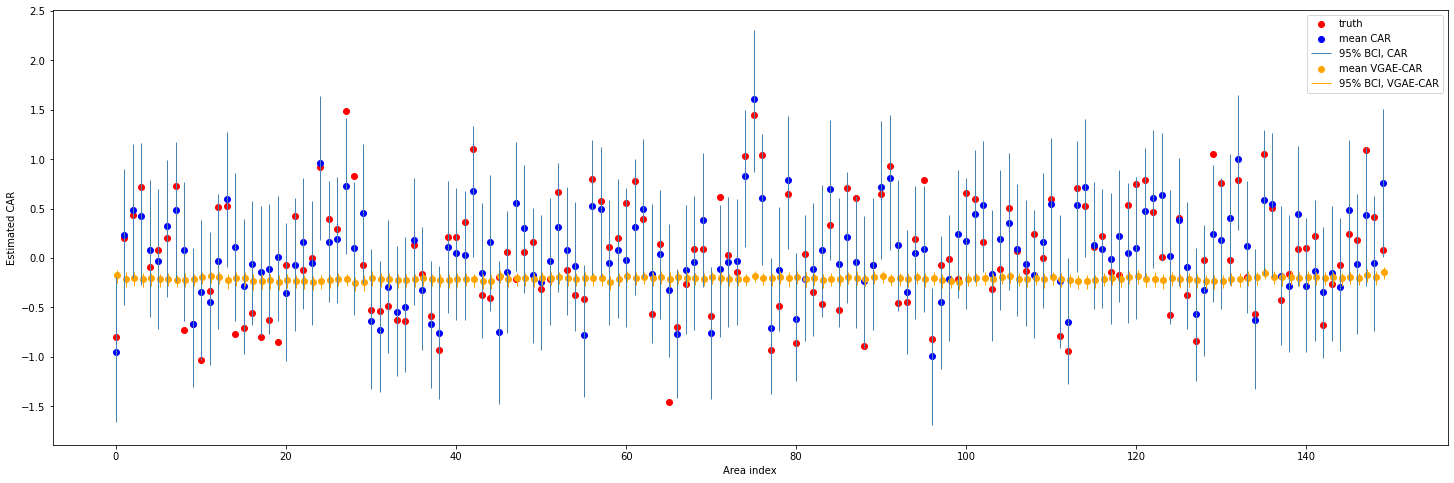

In [ ]:
_, ax = plt.subplots(figsize=(25, 8))

xs = np.arange(0, num_x*num_y)
ax.scatter(xs, y_truth, label="truth", color='red')
ax.scatter(xs, mean_post_pred_car, label="mean CAR", color='blue')
ax.vlines(xs, bci_car_2_5, bci_car_97_5, linestyle="-",  linewidth=1, color='steelblue', label='95% BCI, CAR')
ax.scatter(xs+0.15, mean_post_pred_vae, label="mean VGAE-CAR", color='orange')
ax.vlines(xs+0.15, bci_vae_2_5, bci_vae_97_5, linestyle="-", linewidth=1, color='orange', label='95% BCI, VGAE-CAR')

ax.set_xlabel('Area index')
ax.set_ylabel('Estimated CAR')

plt.legend()
plt.show()

In [ ]:
ARGS

Args(loss_fn=<function compute_mse_loss at 0x14a4b1c10>, hidden_gnn_dim=200, hidden_fc_dim=150, latent_dim=50, output_dim=1, batch_size=500, num_nodes=150, learning_rate=0.01, epochs=1000, eval_frequency=50)